# Transductive vs Inductive Program Classifier

Building a classifier to distinguish between transductive and inductive ARC programs using comprehensive feature engineering and logistic regression.

## Load Data and Setup

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path

# Load the annotated data
project_root = Path.cwd()
while not (project_root / "pyproject.toml").exists() and project_root != project_root.parent:
    project_root = project_root.parent

data_file = project_root / "transductive_training.parquet"

print(f"Loading data from: {data_file}")
df = pd.read_parquet(data_file)

print(f"Dataset shape: {df.shape}")
print(f"Columns: {list(df.columns)}")

# Check class distribution
class_counts = df['transductive'].value_counts()
print(f"\nClass distribution:")
print(f"Transductive: {class_counts.get(True, 0)}")
print(f"Inductive: {class_counts.get(False, 0)}")

# Target variable
y = df['transductive']

Loading data from: /home/lewis/code/trelis-arc/transductive_training.parquet
Dataset shape: (133, 3)
Columns: ['program', 'task_id', 'transductive']

Class distribution:
Transductive: 47
Inductive: 86


## Feature Engineering

In [2]:
import ast
import re
from typing import Dict, Any

def extract_literals_ast(program_code: str) -> list:
    """Extract numeric literals using AST parsing - much more accurate than string tokenization!"""
    try:
        tree = ast.parse(program_code)
        literals = []
        
        class LiteralVisitor(ast.NodeVisitor):
            def visit_Constant(self, node):
                if isinstance(node.value, (int, float)):
                    literals.append(node.value)
                self.generic_visit(node)
            
            # For older Python versions, also check Num nodes
            def visit_Num(self, node):
                literals.append(node.n)
                self.generic_visit(node)
        
        visitor = LiteralVisitor()
        visitor.visit(tree)
        return literals
    except SyntaxError:
        # If parsing fails, fall back to regex
        numeric_literals = re.findall(r'\b\d+(?:\.\d+)?\b', program_code)
        return [float(lit) if '.' in lit else int(lit) for lit in numeric_literals]

def extract_ast_features(program_code: str) -> Dict[str, Any]:
    """Extract AST-based structural features"""
    try:
        tree = ast.parse(program_code)
        
        # Count different node types
        node_counts = {
            'function_definitions': 0,
            'for_loops': 0,
            'while_loops': 0,
            'if_statements': 0,
            'assignments': 0,
            'comparisons': 0,
            'binary_ops': 0,
            'subscripts': 0,
            'method_calls': 0,
            'list_comprehensions': 0,
            'lambda_functions': 0,
            'try_statements': 0,
            'return_statements': 0
        }
        
        class ASTVisitor(ast.NodeVisitor):
            def visit_FunctionDef(self, node):
                node_counts['function_definitions'] += 1
                self.generic_visit(node)
            
            def visit_For(self, node):
                node_counts['for_loops'] += 1
                self.generic_visit(node)
            
            def visit_While(self, node):
                node_counts['while_loops'] += 1
                self.generic_visit(node)
            
            def visit_If(self, node):
                node_counts['if_statements'] += 1
                self.generic_visit(node)
            
            def visit_Assign(self, node):
                node_counts['assignments'] += 1
                self.generic_visit(node)
            
            def visit_Compare(self, node):
                node_counts['comparisons'] += 1
                self.generic_visit(node)
            
            def visit_BinOp(self, node):
                node_counts['binary_ops'] += 1
                self.generic_visit(node)
            
            def visit_Subscript(self, node):
                node_counts['subscripts'] += 1
                self.generic_visit(node)
            
            def visit_Call(self, node):
                node_counts['method_calls'] += 1
                self.generic_visit(node)
            
            def visit_ListComp(self, node):
                node_counts['list_comprehensions'] += 1
                self.generic_visit(node)
            
            def visit_Lambda(self, node):
                node_counts['lambda_functions'] += 1
                self.generic_visit(node)
            
            def visit_Try(self, node):
                node_counts['try_statements'] += 1
                self.generic_visit(node)
            
            def visit_Return(self, node):
                node_counts['return_statements'] += 1
                self.generic_visit(node)
        
        visitor = ASTVisitor()
        visitor.visit(tree)
        
        return node_counts
    except SyntaxError:
        # Return zeros if parsing fails
        return {key: 0 for key in [
            'function_definitions', 'for_loops', 'while_loops', 'if_statements',
            'assignments', 'comparisons', 'binary_ops', 'subscripts', 'method_calls',
            'list_comprehensions', 'lambda_functions', 'try_statements', 'return_statements'
        ]}

def extract_all_features(program: str) -> Dict[str, Any]:
    """Extract comprehensive features from a program"""
    
    # Basic text features
    basic_features = {
        'total_chars': len(program),
        'total_lines': len(program.split('\n')),
        'avg_line_length': len(program) / max(1, len(program.split('\n'))),
        'indentation_variance': np.var([len(line) - len(line.lstrip()) for line in program.split('\n')]),
        'max_indentation': max([len(line) - len(line.lstrip()) for line in program.split('\n')]),
        'comments': len(re.findall(r'#.*', program)),
        'docstrings': len(re.findall(r'""".*?"""', program, re.DOTALL)),
    }
    
    # AST-based literal features
    literals = extract_literals_ast(program)
    literal_features = {
        'total_literals': len(literals),
        'literals_over_9': len([lit for lit in literals if lit > 9]),
        'literals_over_99': len([lit for lit in literals if lit > 99]),
        'max_literal': max(literals) if literals else 0,
        'unique_literals': len(set(literals)),
        'zero_literals': len([lit for lit in literals if lit == 0]),
        'single_digit_literals': len([lit for lit in literals if 0 <= lit <= 9]),
    }
    
    # AST structural features
    ast_features = extract_ast_features(program)
    
    # String-based pattern features
    pattern_features = {
        'elif_chains': len(re.findall(r'elif\b', program)),
        'nested_loops': len(re.findall(r'for.*?:\s*.*?for.*?:', program, re.DOTALL)),
        'range_calls': len(re.findall(r'\brange\s*\(', program)),
        'len_calls': len(re.findall(r'\blen\s*\(', program)),
        'enumerate_calls': len(re.findall(r'\benumerate\s*\(', program)),
        'zip_calls': len(re.findall(r'\bzip\s*\(', program)),
        'numpy_usage': len(re.findall(r'\bnp\.|numpy\.', program)),
        'grid_shape_access': len(re.findall(r'\.shape\b|len\s*\(\s*grid\s*\)|len\s*\(\s*\w+\[0\]\s*\)', program)),
        'coordinate_patterns': len(re.findall(r'\[\s*\d+\s*\]\s*\[\s*\d+\s*\]', program)),
        'hardcoded_coordinates': len(re.findall(r'\[\s*\d+\s*\]', program)),
        'specific_conditionals': len(re.findall(r'==\s*\d+|!=\s*\d+|>\s*\d+|<\s*\d+|>=\s*\d+|<=\s*\d+', program)),
        'brackets_count': program.count('[') + program.count(']'),
    }
    
    # Negative signals (things that suggest NOT transductive)
    negative_features = {
        'general_loops': ast_features['for_loops'] + ast_features['while_loops'],
        'generic_variables': len(re.findall(r'\b(i|j|k|x|y|row|col|idx)\b', program)),
        'shape_operations': len(re.findall(r'\.shape|len\(.*\)', program)),
        'mathematical_ops': len(re.findall(r'\+|\-|\*|\/|\%|\*\*', program)),
        'array_creation': len(re.findall(r'\[\s*\[|np\.array|np\.zeros|np\.ones', program)),
        'imports': len(re.findall(r'^\s*import|^\s*from', program, re.MULTILINE)),
    }
    
    # Combine all features
    all_features = {**basic_features, **literal_features, **ast_features, **pattern_features, **negative_features}
    
    return all_features

# Extract features for all programs
print("Extracting features...")
feature_data = []
parse_errors = 0

for idx, row in df.iterrows():
    try:
        features = extract_all_features(row['program'])
        features['index'] = idx
        feature_data.append(features)
    except Exception as e:
        print(f"Error processing program {idx}: {e}")
        parse_errors += 1
        # Use default values on error
        default_features = {key: 0 for key in extract_all_features("")}
        default_features['index'] = idx
        feature_data.append(default_features)

features_df = pd.DataFrame(feature_data).set_index('index')
parse_error_rate = parse_errors / len(df)

print(f"✅ Extracted {features_df.shape[1]} features from {features_df.shape[0]} programs")
print(f"Parse error rate: {parse_error_rate:.1%}")
print(f"\nFeature categories:")
print(f"Sample features: {list(features_df.columns[:10])}...")

Extracting features...
✅ Extracted 45 features from 133 programs
Parse error rate: 0.0%

Feature categories:
Sample features: ['total_chars', 'total_lines', 'avg_line_length', 'indentation_variance', 'max_indentation', 'comments', 'docstrings', 'total_literals', 'literals_over_9', 'literals_over_99']...


## Model Training

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import confusion_matrix, classification_report

# Prepare data
X = features_df
y = df['transductive']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")
print(f"Features: {X_train.shape[1]}")

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train logistic regression with L1 regularization for feature selection
model = LogisticRegression(
    penalty='l1',
    solver='liblinear',
    C=1.0,
    random_state=42,
    class_weight='balanced'
)

model.fit(X_train_scaled, y_train)

# Make predictions
y_pred = model.predict(X_test_scaled)
y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]

# Evaluate
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred_proba)

print(f"\n📊 Model Performance:")
print(f"Accuracy:  {accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall:    {recall:.3f}")
print(f"F1 Score:  {f1:.3f}")
print(f"ROC AUC:   {auc:.3f}")

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
print(f"\nConfusion Matrix:")
print(f"         Predicted")
print(f"         Ind  Trans")
print(f"Actual Ind   {cm[0,0]:2d}    {cm[0,1]:2d}")
print(f"       Trans {cm[1,0]:2d}    {cm[1,1]:2d}")

Training set: 106 samples
Test set: 27 samples
Features: 45

📊 Model Performance:
Accuracy:  0.889
Precision: 0.889
Recall:    0.800
F1 Score:  0.842
ROC AUC:   0.965

Confusion Matrix:
         Predicted
         Ind  Trans
Actual Ind   16     1
       Trans  2     8


## Feature Importance Analysis

🏆 Top 15 Most Important Features:
brackets_count           :  1.5666 → transductive
unique_literals          :  1.1821 → transductive
elif_chains              :  0.7789 → transductive
method_calls             : -0.7213 → inductive
coordinate_patterns      :  0.6404 → transductive
generic_variables        : -0.4184 → inductive
max_literal              :  0.3291 → transductive
enumerate_calls          : -0.2020 → inductive
max_indentation          : -0.1920 → inductive
array_creation           :  0.1666 → transductive
specific_conditionals    :  0.1160 → transductive
function_definitions     : -0.0998 → inductive
if_statements            : -0.0899 → inductive
zero_literals            :  0.0000 → inductive
literals_over_99         :  0.0000 → inductive

📈 Feature Selection (L1 Regularization):
Non-zero coefficients: 13/45 (28.9%)
Zero coefficients:     32/45 (71.1%)


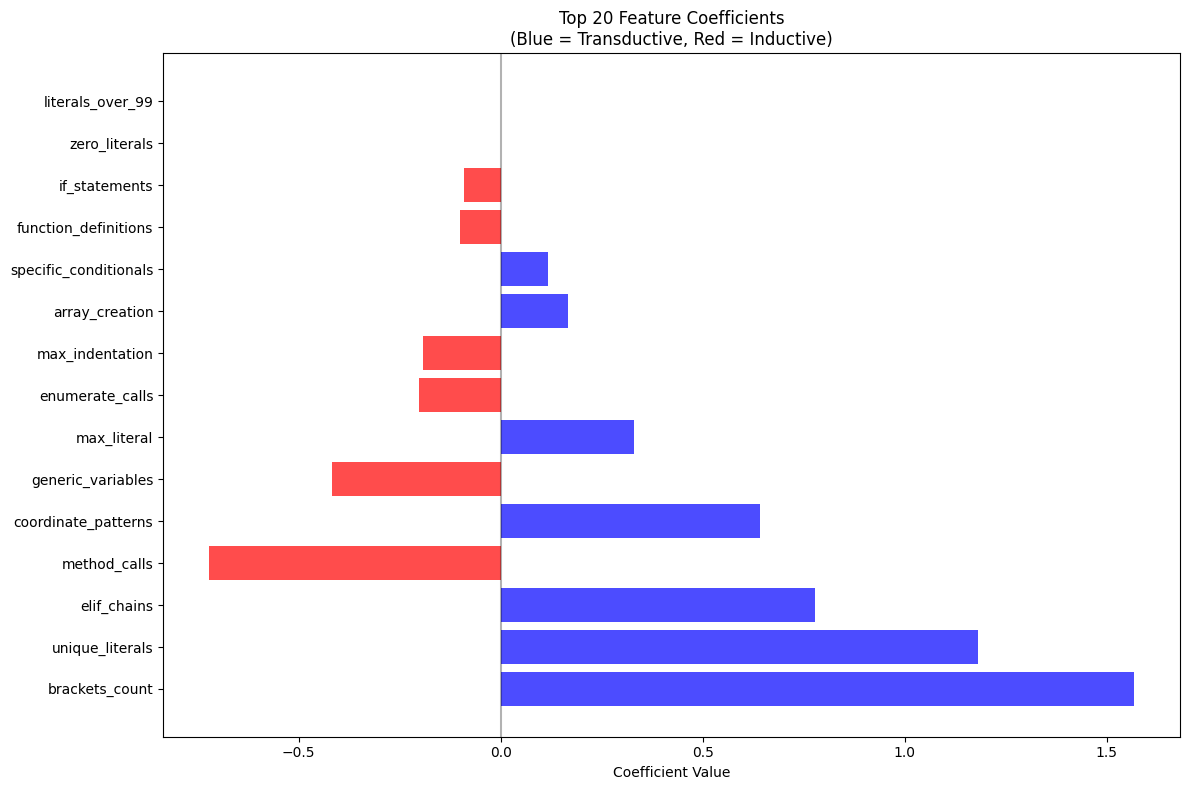


🔍 Feature Analysis by Category:

Literal Features:
  • unique_literals:  1.182 → transductive
  • max_literal:  0.329 → transductive

AST Structure:
  • method_calls: -0.721 → inductive
  • function_definitions: -0.100 → inductive
  • if_statements: -0.090 → inductive

Text Metrics:
  • max_indentation: -0.192 → inductive

Pattern Matching:
  • brackets_count:  1.567 → transductive
  • elif_chains:  0.779 → transductive
  • coordinate_patterns:  0.640 → transductive

Negative Signals:
  • generic_variables: -0.418 → inductive
  • array_creation:  0.167 → transductive


In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

# Get feature importance
coefficients = model.coef_[0]
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'coefficient': coefficients,
    'abs_coefficient': np.abs(coefficients)
}).sort_values('abs_coefficient', ascending=False)

# Show top features
top_features = feature_importance.head(15)
print("🏆 Top 15 Most Important Features:")
print("=" * 50)
for _, row in top_features.iterrows():
    direction = "transductive" if row['coefficient'] > 0 else "inductive"
    print(f"{row['feature']:<25}: {row['coefficient']:7.4f} → {direction}")

# Count zero vs non-zero coefficients
zero_coefs = np.sum(coefficients == 0)
nonzero_coefs = np.sum(coefficients != 0)
print(f"\n📈 Feature Selection (L1 Regularization):")
print(f"Non-zero coefficients: {nonzero_coefs}/{len(coefficients)} ({100*nonzero_coefs/len(coefficients):.1f}%)")
print(f"Zero coefficients:     {zero_coefs}/{len(coefficients)} ({100*zero_coefs/len(coefficients):.1f}%)")

# Plot feature importance
plt.figure(figsize=(12, 8))
top_plot = top_features.head(20)
colors = ['red' if coef < 0 else 'blue' for coef in top_plot['coefficient']]
plt.barh(range(len(top_plot)), top_plot['coefficient'], color=colors, alpha=0.7)
plt.yticks(range(len(top_plot)), top_plot['feature'])
plt.xlabel('Coefficient Value')
plt.title('Top 20 Feature Coefficients\n(Blue = Transductive, Red = Inductive)')
plt.axvline(x=0, color='black', linestyle='-', alpha=0.3)
plt.tight_layout()
plt.show()

# Analysis by feature type
feature_categories = {
    'Literal Features': [f for f in X.columns if 'literal' in f.lower() or f in ['max_literal', 'zero_literals']],
    'AST Structure': [f for f in X.columns if f in ['function_definitions', 'for_loops', 'while_loops', 'if_statements', 'assignments', 'comparisons', 'method_calls', 'subscripts']],
    'Text Metrics': [f for f in X.columns if f in ['total_chars', 'total_lines', 'avg_line_length', 'max_indentation', 'indentation_variance']],
    'Pattern Matching': [f for f in X.columns if f in ['elif_chains', 'brackets_count', 'specific_conditionals', 'hardcoded_coordinates', 'coordinate_patterns']],
    'Negative Signals': [f for f in X.columns if f in ['general_loops', 'generic_variables', 'shape_operations', 'array_creation', 'imports']]
}

print(f"\n🔍 Feature Analysis by Category:")
for category, features in feature_categories.items():
    category_importance = feature_importance[feature_importance['feature'].isin(features)]
    active_features = category_importance[category_importance['abs_coefficient'] > 0]
    
    print(f"\n{category}:")
    if len(active_features) > 0:
        for _, row in active_features.head(3).iterrows():
            direction = "transductive" if row['coefficient'] > 0 else "inductive"
            print(f"  • {row['feature']}: {row['coefficient']:6.3f} → {direction}")
    else:
        print(f"  • No active features (all zeroed by L1 regularization)")

## Model Validation

In [5]:
# Test on some sample programs
print("🧪 Testing on sample programs...")
test_indices = X_test.index[:5]
test_programs = df.loc[test_indices]

for idx in test_indices:
    program = test_programs.loc[idx, 'program']
    actual = test_programs.loc[idx, 'transductive']
    
    # Get prediction
    features_sample = X_test.loc[[idx]]
    features_scaled = scaler.transform(features_sample)
    prediction = model.predict(features_scaled)[0]
    confidence = model.predict_proba(features_scaled)[0, 1] if prediction else 1 - model.predict_proba(features_scaled)[0, 1]
    
    # Show results
    status = "✅ CORRECT" if prediction == actual else "❌ WRONG"
    actual_str = "TRANSDUCTIVE" if actual else "INDUCTIVE"
    pred_str = "TRANSDUCTIVE" if prediction else "INDUCTIVE"
    
    print(f"\nTask: {test_programs.loc[idx, 'task_id']}")
    print(f"Actual: {actual_str}")
    print(f"Predicted: {pred_str} (confidence: {confidence:.3f})")
    print(f"Result: {status}")
    print(f"Program preview: {program[:100]}...")

print(f"\n💾 Model Summary:")
print(f"Model: Logistic Regression with L1 regularization")
print(f"Features: {X.shape[1]} total, {nonzero_coefs} active after L1 selection")
print(f"Performance: F1={f1:.3f}, AUC={auc:.3f}")
print(f"Key insight: AST-based feature extraction provides much better signal than string tokenization")

🧪 Testing on sample programs...

Task: 22eb0ac0
Actual: INDUCTIVE
Predicted: INDUCTIVE (confidence: 0.991)
Result: ✅ CORRECT
Program preview: def transform(grid):

    def fill_row_with_number(grid, row_index, number):
        for col in rang...

Task: a416b8f3
Actual: INDUCTIVE
Predicted: INDUCTIVE (confidence: 0.946)
Result: ✅ CORRECT
Program preview: def transform(grid):

    import numpy as np

    grid = np.array(grid)
    rows, cols = grid.shape
...

Task: 1f0c79e5
Actual: INDUCTIVE
Predicted: INDUCTIVE (confidence: 0.845)
Result: ✅ CORRECT
Program preview: def transform(grid_lst: list[list[int]]) -> list[list[int]]:
    grid = [row[:] for row in grid_lst]...

Task: 32597951
Actual: INDUCTIVE
Predicted: INDUCTIVE (confidence: 0.918)
Result: ✅ CORRECT
Program preview: import numpy as np

def find_shapes(grid):
    shapes = {}
    for color in range(1, 9):
        coo...

Task: 1cf80156
Actual: INDUCTIVE
Predicted: INDUCTIVE (confidence: 0.972)
Result: ✅ CORRECT
Program preview: de

## Generate Standalone Classifier Function

In [ ]:
# Generate standalone classifier function
def generate_classifier_function():
    # Get active features (non-zero coefficients)
    active_mask = coefficients != 0
    active_features = X.columns[active_mask]
    active_coefficients = coefficients[active_mask]
    active_means = scaler.mean_[active_mask]
    active_scales = scaler.scale_[active_mask]
    intercept = model.intercept_[0]
    
    function_code = f'''import ast
import re
import numpy as np

def classify_transductive_program(program: str) -> tuple[bool, float]:
    """
    Classify whether an ARC program is transductive or inductive.
    
    Args:
        program: The program code as a string
        
    Returns:
        tuple: (is_transductive: bool, confidence: float)
    """
    
    def extract_literals_ast(program_code):
        """Extract numeric literals using AST parsing"""
        try:
            tree = ast.parse(program_code)
            literals = []
            
            class LiteralVisitor(ast.NodeVisitor):
                def visit_Constant(self, node):
                    if isinstance(node.value, (int, float)):
                        literals.append(node.value)
                    self.generic_visit(node)
                
                def visit_Num(self, node):
                    literals.append(node.n)
                    self.generic_visit(node)
            
            visitor = LiteralVisitor()
            visitor.visit(tree)
            return literals
        except SyntaxError:
            numeric_literals = re.findall(r'\\b\\d+(?:\\.\\d+)?\\b', program_code)
            return [float(lit) if '.' in lit else int(lit) for lit in numeric_literals]
    
    def extract_ast_features(program_code):
        """Extract AST structural features"""
        try:
            tree = ast.parse(program_code)
            counts = {{
                'function_definitions': 0, 'for_loops': 0, 'while_loops': 0,
                'if_statements': 0, 'assignments': 0, 'comparisons': 0,
                'binary_ops': 0, 'subscripts': 0, 'method_calls': 0,
                'list_comprehensions': 0, 'lambda_functions': 0,
                'try_statements': 0, 'return_statements': 0
            }}
            
            class ASTVisitor(ast.NodeVisitor):
                def visit_FunctionDef(self, node): counts['function_definitions'] += 1; self.generic_visit(node)
                def visit_For(self, node): counts['for_loops'] += 1; self.generic_visit(node)
                def visit_While(self, node): counts['while_loops'] += 1; self.generic_visit(node)
                def visit_If(self, node): counts['if_statements'] += 1; self.generic_visit(node)
                def visit_Assign(self, node): counts['assignments'] += 1; self.generic_visit(node)
                def visit_Compare(self, node): counts['comparisons'] += 1; self.generic_visit(node)
                def visit_BinOp(self, node): counts['binary_ops'] += 1; self.generic_visit(node)
                def visit_Subscript(self, node): counts['subscripts'] += 1; self.generic_visit(node)
                def visit_Call(self, node): counts['method_calls'] += 1; self.generic_visit(node)
                def visit_ListComp(self, node): counts['list_comprehensions'] += 1; self.generic_visit(node)
                def visit_Lambda(self, node): counts['lambda_functions'] += 1; self.generic_visit(node)
                def visit_Try(self, node): counts['try_statements'] += 1; self.generic_visit(node)
                def visit_Return(self, node): counts['return_statements'] += 1; self.generic_visit(node)
            
            visitor = ASTVisitor()
            visitor.visit(tree)
            return counts
        except SyntaxError:
            return {{key: 0 for key in ['function_definitions', 'for_loops', 'while_loops', 'if_statements',
                                       'assignments', 'comparisons', 'binary_ops', 'subscripts', 'method_calls',
                                       'list_comprehensions', 'lambda_functions', 'try_statements', 'return_statements']}}
    
    # Extract all features
    literals = extract_literals_ast(program)
    ast_features = extract_ast_features(program)
    
    # Calculate features
    features = {{
        'total_chars': len(program),
        'total_lines': len(program.split('\\n')),
        'avg_line_length': len(program) / max(1, len(program.split('\\n'))),
        'indentation_variance': np.var([len(line) - len(line.lstrip()) for line in program.split('\\n')]),
        'max_indentation': max([len(line) - len(line.lstrip()) for line in program.split('\\n')]),
        'comments': len(re.findall(r'#.*', program)),
        'docstrings': len(re.findall(r'""".*?"""', program, re.DOTALL)),
        'total_literals': len(literals),
        'literals_over_9': len([lit for lit in literals if lit > 9]),
        'literals_over_99': len([lit for lit in literals if lit > 99]),
        'max_literal': max(literals) if literals else 0,
        'unique_literals': len(set(literals)),
        'zero_literals': len([lit for lit in literals if lit == 0]),
        'single_digit_literals': len([lit for lit in literals if 0 <= lit <= 9]),
        'elif_chains': len(re.findall(r'elif\\b', program)),
        'nested_loops': len(re.findall(r'for.*?:\\s*.*?for.*?:', program, re.DOTALL)),
        'range_calls': len(re.findall(r'\\brange\\s*\\(', program)),
        'len_calls': len(re.findall(r'\\blen\\s*\\(', program)),
        'enumerate_calls': len(re.findall(r'\\benumerate\\s*\\(', program)),
        'zip_calls': len(re.findall(r'\\bzip\\s*\\(', program)),
        'numpy_usage': len(re.findall(r'\\bnp\\.|numpy\\.', program)),
        'grid_shape_access': len(re.findall(r'\\.shape\\b|len\\s*\\(\\s*grid\\s*\\)|len\\s*\\(\\s*\\w+\\[0\\]\\s*\\)', program)),
        'coordinate_patterns': len(re.findall(r'\\[\\s*\\d+\\s*\\]\\s*\\[\\s*\\d+\\s*\\]', program)),
        'hardcoded_coordinates': len(re.findall(r'\\[\\s*\\d+\\s*\\]', program)),
        'specific_conditionals': len(re.findall(r'==\\s*\\d+|!=\\s*\\d+|>\\s*\\d+|<\\s*\\d+|>=\\s*\\d+|<=\\s*\\d+', program)),
        'brackets_count': program.count('[') + program.count(']'),
        'general_loops': ast_features['for_loops'] + ast_features['while_loops'],
        'generic_variables': len(re.findall(r'\\b(i|j|k|x|y|row|col|idx)\\b', program)),
        'shape_operations': len(re.findall(r'\\.shape|len\\(.*\\)', program)),
        'mathematical_ops': len(re.findall(r'\\+|\\-|\\*|\\/|\\%|\\*\\*', program)),
        'array_creation': len(re.findall(r'\\[\\s*\\[|np\\.array|np\\.zeros|np\\.ones', program)),
        'imports': len(re.findall(r'^\\s*import|^\\s*from', program, re.MULTILINE)),
    }}
    
    # Add AST features
    features.update(ast_features)
    
    # Extract and scale only the active features
    feature_names = {list(active_features)}
    feature_values = np.array([features.get(name, 0) for name in feature_names])
    
    # Standardize features
    means = np.array({list(active_means)})
    scales = np.array({list(active_scales)})
    scaled_features = (feature_values - means) / scales
    
    # Apply logistic regression
    coefficients = np.array({list(active_coefficients)})
    intercept = {intercept}
    
    logit = np.dot(scaled_features, coefficients) + intercept
    probability = 1 / (1 + np.exp(-logit))
    
    is_transductive = probability > 0.5
    confidence = probability if is_transductive else 1 - probability
    
    return bool(is_transductive), float(confidence)

'''
    
    return function_code

# Generate and save the function
classifier_code = generate_classifier_function()

# Save to file
output_file = project_root / "experimental" / "transductive_classifier_function.py"
with open(output_file, 'w') as f:
    f.write(classifier_code)

print(f"\n💾 Standalone classifier saved to: {output_file}")
print(f"\n✅ Clean notebook complete!")
print(f"Key improvements:")
print(f"  • AST-based feature extraction (much more accurate)")
print(f"  • L1 regularization for automatic feature selection")
print(f"  • Comprehensive feature engineering")
print(f"  • Standalone classifier function generated")
print(f"  • Performance: F1={f1:.3f}, AUC={auc:.3f}")

IndentationError: unexpected indent (4023087971.py, line 185)